# Accumulator

In this notebook, we study the statistics of a synapse receiving input from the accumulator.

In previous notebooks, we studied the statistics of a synapse with input spikes derived from various processes including Poisson, periodic, p-thinned period, and gamma processes. Those analysis assumed
1. the input spike train interspike intervals (ISI)s were independent and identically distributed (IID)
2. the input spike train ISIs followed a given distribution

Here, we do not assume a particular ISI distribution for the synapse input or that the ISI are IID. Instead, we first study the statistics of the accumulator. It would be very nice if the accumulator output ISIs turned out to be IID, and in fact, we will show that under certain conditions the accumulator output indeed is IID with a gamma distribution. However, under many other conditions, the accumulator output turns out to not be IID or have a nice distribution. 

The following factors relate to the assumption that the accumulator output spikes are IID~gamma:
* Neurons spiking is closer to regular (periodic) than to Poisson in small NEF networks, so the accumulator output ISIs may not be gamma-distributed.
* Neuron spiking can become very correlated in many-layered, feed-foward NEF networks, so the accumulator output may not be gamma-distributed or independent.
* The accumulator can carry-over state from one spike to the next so the ISI are not strictly independent. 
* The accumulator receives input from many neurons: This might work in our favor becuase the superposition of many non-Poisson processes can have an effect that is equivalent to a Poisson process. In addition, if the spike weights are small relative to the threshold, the carry-over from one ISI to the next might be trivial. As usual, the devil is in the details.

In the rest of this notebook, we work towards whether the accumulator output can be assumed as IID under realistic conditions.
***Perhaps*** we will conclude that the accumulator inputs under realistic conditions are effectively Poisson, so that the output ISI are approximately IID-gamma with shape parameter $\frac{\sum_i a_id_i}{T}$ where $a_i$ is the spike rate of the $i$th neuron, $d_i$ is its decode weight, and $T$ is the threshold.

## Mathematical Description

The accumulator is parameterized by a threshold $T$. Below threshold, the accumulator is exactly an integrator. Specifically,

$$
\dot{x} = u
$$

where $x$ is the accumulator state and $u$ is the accumulator input. The accumulator input expressed by

$$u=\sum_{i=1}^N\sum_{j=1}^{K(i)} d_i\delta(t-t_{i,j})$$

where
* $N$ is the number of input neurons
* $K(i)$ is the number spikes emmited by the $i$th neuron
* $d_i$ is the decode weight of the $i$th neuron
* $t_{i,j}$ is the time of the $i$

The accumulator state is initially 0, and the threshold is 2-sided so that when the accumulator reaches $T$ ($-T$), it outputs a positive (negative) spike and resets its state towards 0 by $T$. We'll assume that the accumulator can only emit one spike at time because, as we'll see, the hardware does not support multiple, simultaneous output spikes. In other words, we constrain the input spike weights so that a single spike cannot drive the accumulator so far past its threshold that the carry over from one ISI to the next also trips the threshold.
th neuron's $j$th spike

We can write the within-threshold accumulator state as

$$
x = \sum_i\sum_j d_iH(t-t_{i,j})
$$

where $H(\cdot)$ is the Heaviside step function.

## Structure and Operation

The accumulator is 15 bits wide and uses the <a href="https://en.wikipedia.org/wiki/Ones%27_complement">one's complement</a> number representation. Each entry in the weight memory is 8 bits wide and also uses the one's complement number representation. In one's complement, the highest order bit indicates the sign while the lower order bits indicate the value. To convert between positive and negative numbers, flip all of the bits in the number. A 3-bit example is given as follows:

<table class="table-bordered">
<tr>
    <th colspan=9>3-bit one's complement example</th>
</tr>
<tr>
    <th>value</th> <th colspan=3>bit position</th> <th></th> <th>value</th> <th colspan=3>bit position</th>
</tr>
<tr>
    <th></th> <th>2</th> <th>1</th> <th>0</th> <th></th> <th></th> <th>2</th> <th>1</th> <th>0</th>
</tr>
<tr>
    <th>0</th> <td>0</td> <td>0</td> <td>0</td> <td></td> <th>-0</th> <td>1</td> <td>1</td> <td>1</td> 
</tr>
<tr>
    <th>1</th> <td>0</td> <td>0</td> <td>1</td> <td></td> <th>-1</th> <td>1</td> <td>1</td> <td>0</td> 
</tr>
<tr>
    <th>2</th> <td>0</td> <td>1</td> <td>0</td> <td></td> <th>-2</th> <td>1</td> <td>0</td> <td>1</td> 
</tr>
<tr>
    <th>3</th> <td>0</td> <td>1</td> <td>1</td> <td></td> <th>-3</th> <td>1</td> <td>0</td> <td>0</td> 
</tr>
</table>

For the given bit widths and the one's complement number system, the accumulator and each weight represent integers in the range [-16384:16384] and [-127:127], respectively.

When a neuron emits a spike, we lookup
* the neuron's decode weight from the weight memory
* the current decoded value from the accumulator memory
* the 3 threshold bits from the accumulator memory

We load the current decoded value into the accumulator and add the weight's value to the current decoded value. Since the weight has fewer bits than the current decoded value, we perform a sign extension to the weight before adding the two. Sign extension means adding extra higher order bits with the same value as the current highest order bit, which indicates the sign. Consider the following examples showing addition of 4 and 3 bit numbers.

<pre><code>
Example: 0+1=1

  0 0 0 0      0 in 4 bits
+   0 0 1    + 1 in 3 bits
---------    ---
  0 0 0 0      0
+ 0 0 0 1    + 1 now sign extended to 4 bits
---------    ---
  0 0 0 1      1 as we expect

Note how we padded the 3 bit number with a 0 because its sign bit was 0.
</code></pre>

<pre><code>
Example: 0-1=-1

  0 0 0 0       0  in 4 bits
+   1 1 0    +(-1) in 3 bits
---------    -----
  0 0 0 0       0
+ 1 1 1 0    +(-1) now sign extended to 4 bits
---------    -----
  1 1 1 0      -1  as we expect

Note how we padded the 3 bit number with a 1 because its sign bit was 1.
</code></pre>

<pre><code>
Example: -1+1=-0

  1 1 1 0     -1 in 4 bits
+   0 0 1    + 1 in 3 bits
---------    ---
  1 1 1 0     -1 
+ 0 0 0 1    + 1 now sign extended to 4 bits
---------    ---
  1 1 1 1     -0 as we expect

The negative sign on the 0 maybe disconcerting, but it will be fine in the one's complement system.
Consider the next example.
</code></pre>

<pre><code>
Example: -0+1=1

  1 1 1 1     -0 in 4 bits
+   0 0 1    + 1 in 3 bits
---------    ---
  1 1 1 1     -0 
+ 0 0 0 1    + 1 now sign extended to 4 bits
---------    ---
  0 0 0 0      0 Perform the addition. It generates a carry out of the highest order bit.
+       1    + 1 In one's complement, we add the generated carry bit to the lowest order bit.
---------    --- 
  0 0 0 1      1 as we expect
</code></pre>


After adding the current decoded value and the weight, we consider the 3 threshold bits. The threshold bits indicate which of the 8 bit positions in the accumulator (shown below) are used for thresholding. When the addition of the weight and the current decoded value causes a transition in the threshold bit (i.e. the decoded value passes the threshold in either the positive or negative direction), an output spike is emitted and the decoded value is shifted back towards 0 by the value of the threshold. Whether a 0->1 or 1->0 transition trips the threshold depends on the sign of the weight being added. For a negative weight, we look for a 1->0 transition, and for a positive weight, we look for a 0->1 transition.

As shown in the following table, bits within positions 6-13 can be used as a threshold bit. Note that the threshold bits overlap with the bitwidth of the weight value, so we may configure a threshold and weight such that each spike in generates a spike out.

<table class="table table-bordered">
    <tr>
        <th colspan=15 style="text-align:center">
            accumulator bit position
        </th>
    </tr>
    <tr class="testrow">
        <td>14</td> <td>13</td> <td>12</td> <td>11</td> <td>10</td>
        <td>9</td> <td>8</td> <td>7</td> <td>6</td> <td>5</td>
        <td>4</td> <td>3</td> <td>2</td> <td>1</td> <td>0</td>
    </tr>
    <tr>
        <td colspan=8></td><th colspan=7 style="text-align:center">weight value</th>
    </tr>
    <tr>
        <td></td><th colspan=8 style="text-align:center">threshold bits</th><td colspan=6></td>
    </tr>
</table>

Note that we must ensure that the weight magnitude $\le$ threshold magnitude. Weight magnitudes greater than the threshold are only possible when the threshold is set to bit position 6, which corresponds to a value of 64. If we allow weights greater than the threshold, we would produce trapped bits that could cause the accumulator to operate incorrectly. To illustrate this, consider the following example with the accumulator adding weights $>$ threshold.

<pre><code>
Threshold position = 6
Threshold value    = 64 = 000 0000 0100 0000
weight             = 65 =          0100 0001

    0 initial decoded value
+  65 add weight
-----
   65 crosses positive threshold
-  64 subtract threshold
-----
    1
+  65 add weight
-----
   66 crosses positive threshold
-  64 subtract threshold
-----
    2 note how remainder increments after threshold subtraction with each spike
  ... after 61 more spikes
-----
   63
+  65 add weight
-----
  128 = 000 0000 1000 0000
        accumulator will not detect change in threshold bit and will miss a spike
        bit will be stranded above the threshold
        If enough stranded bits are accumulated, we could flip the sign of the decoded value.
</code></pre>

Because we prohibit weights greater than the threshold and because of its design, the accumulator **does not and cannot** output more than 1 spike at a time. Given the maximum weight constraint, it is helpful to think of the weights in units of threshold. Increasing the threshold value reduces the maximum weight value and the minimum weight unit, which would make our weight representation more precision. That is, we can trade off dynamic range for precision. The following table tabulates the possible threshold positions and their associated maximum weights, and precision. 

<table class="table table-bordered">
    <tr>
        <th colspan=2>Threshold</th> <td colspan=3> </td>
    </tr>
    <tr>
        <th>Position</th> <th>Value</th> <th>Max Weight</th> <th>Max Weight/Threshold</th> <th>1/Threshold (precision)</th>
    </tr>
    <tr>
        <td>6</td> <td>64</td> <td>64</td> <td>1</td> <td>1/64</td> 
    </tr>
    <tr>
        <td>7</td> <td>128</td> <td>127</td> <td>127/128</td> <td>1/128</td> 
    </tr>
    <tr>
        <td>8</td> <td>256</td> <td>127</td> <td>127/256</td> <td>1/256</td> 
    </tr>
    <tr>
        <td>9</td> <td>512</td> <td>127</td> <td>127/512</td> <td>1/512</td> 
    </tr>
    <tr>
        <td>10</td> <td>1024</td> <td>127</td> <td>127/1024</td> <td>1/1024</td> 
    </tr>
    <tr>
        <td>11</td> <td>2048</td> <td>127</td> <td>127/2048</td> <td>1/2048</td> 
    </tr>    
    <tr>
        <td>12</td> <td>4096</td> <td>127</td> <td>127/4096</td> <td>1/4096</td> 
    </tr>
    <tr>
        <td>13</td> <td>8192</td> <td>127</td> <td>127/8192</td> <td>1/8192</td> 
    </tr>
</table>



# Setting a Threshold and Computing Decode Weights

The chip does not communicate between neurons with fixed or floating point numbers but rather spikes, so we map a $x$ to a spike rate $f$ for communication between neurons. Users typically build their networks so that $x$ operates within the range $[-1:1]$. Spikes are signed, so we can represent "negative" rates. We could pick from a number of mappings, but we'll examine a simple linear mapping to convert $x$ to $f$

$$
f=f_{max}x
$$

where $f_{max}$ is the maximum firing rate since $x$ operates from -1 to 1. While simple, this does tie our signal-to-noise ratio to our position in the space of $x$...

Each spike in to the accumulator will be weighted and added to a running sum (i.e. the decoded value). Assuming that the accumulator is always driven towards the positive threshold, the value accumulated over a certain period of time will be given by

$$
\frac{\textrm{spikes_in}}{\textrm{s}}\cdot\frac{\textrm{weight}}{\textrm{spike_in}}\cdot \textrm{time} = \textrm{value accumulated}
$$

We can then apply the threshold to find the number of threshold crossings, or output spikes.

$$
\frac{\textrm{value accumulated}}{\textrm{threshold}}=\textrm{# threshold crossings}=\textrm{spikes out}
$$

To find the output rate, we divide the number of spikes out by the time

$$
\frac{\textrm{spikes out}}{\textrm{time}}=\frac{\textrm{spikes_in}}{\textrm{s}}\cdot\frac{\textrm{weight}}{\textrm{spike_in}}\cdot\frac{1}{\textrm{threshold}}
$$

for $N$ neurons spiking at rates $a_n$ with weights $d_n$ and accumulator with threshold $T$, we can rewrite the previous discussion in the following equation

\begin{align*}
\frac{\sum_{n=1}^Na_nd_n}{T} &= f_{out} \\
\sum_{n=1}^Na_nd_n &= f_{out}T
\end{align*}

That is, the threshold simply divides the accumulated value, so we should scale our decode weights by the accumulator threshold to generate the desired output firing rate.

# Simulations

First we run simulations with a a single neuron. We show that it is possible to get a few different output spiking distributions. Next we move to multiple neurons and actual NEF networks built by nengo to setup our simulations.

In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from datatypes import SpikeTrain, set_list_var
from pool import build_pool
from exp import (
    run_experiment,
    run_regular_neuron_experiment,
    run_poisson_neuron_experiment,
    plot_timeseries, plot_isi, plot_gamma,
    compute_out_rate
)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import nengo
from nengo.utils.ensemble import tuning_curves

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Single Regular Spiking Neuron

Let's test the accumulator with a single, regular spiking neuron. We can expect two sets of behavior:
1. The accumulator simply decimates the input spike train when the threshold is a multiple of the weight.
2. The accumulator introduces variation in the output spike train when the threshold is not a multiple of the weight

### Threshold = Multiple of Weight
First we consider when the threshold is a multiple of the neuron's weight.

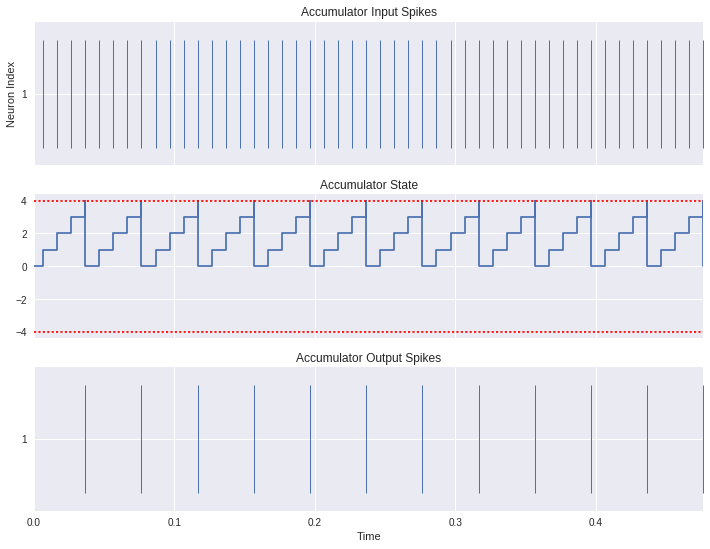

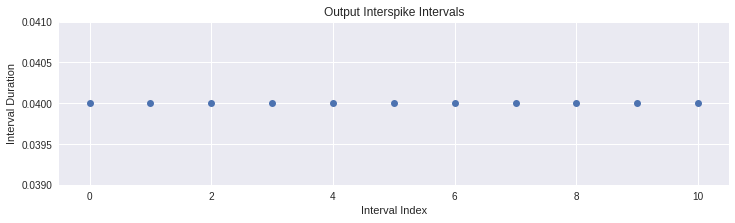

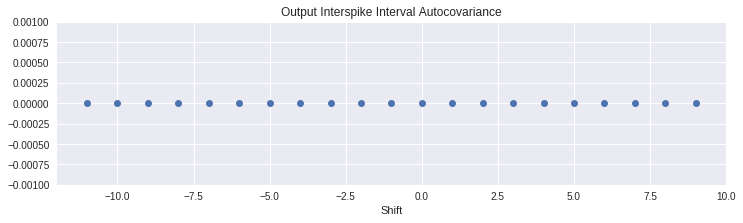

In [2]:
run_regular_neuron_experiment(weight=1, threshold=4)

From top to bottom, the first plot shows the neuron's spikes that are fed as input to the accumulator. The second plot shows the accumulator state in response to the neuron's spikes. Each input spike produces a jump of 1 unit in the accumulator state because the weight is 1. When the accumulator reaches its threshold of 4, shown as a dotted red line, it emits an output spike as shown in the third plot. The bottom two plots show the accumulator output ISIs and their autocovariance.

Unsurprisingly, all of the output inter-spike intervals are the same. The accumulator simply decimates the traffic by the  weight/threshold ratio as expected. A synapse receiving input from this accumulator would have the same statistics as one receiving input from a regularly spiking neuron operating at the accumulator's output rate.

### Threshold $\neq$ Multiple of Weight

Next, we consider the case when the threshold is not a multiple of the neuron's weight.

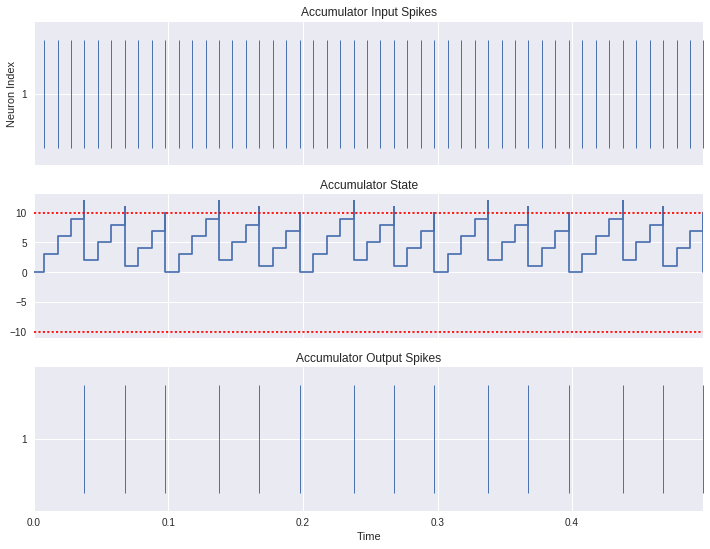

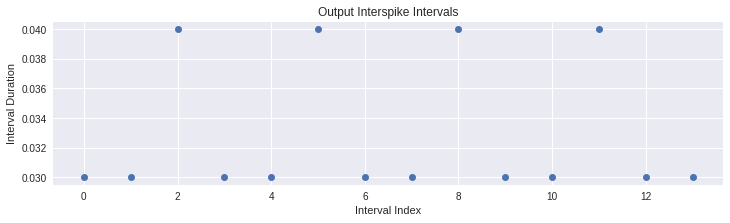

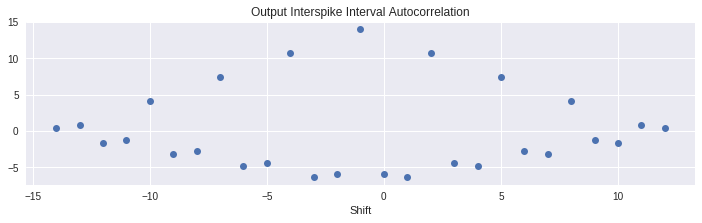

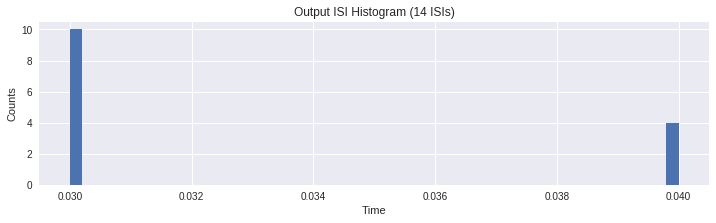

In [3]:
run_regular_neuron_experiment(weight=3, threshold=10)

As the plots of the output ISI, output ISI autocorrelation, and output ISI histogram show, the output spikes are no longer periodic, and the output ISI are certainly not independent. 

While we skip the analysis, a synapse receiving input from this accumulator would actually have a lower SNR as one receiving input from a regularly spiking neuron operating at the accumulator's output rate.

## Single Poisson Spiking Neuron

Now let's test the accumulator with a single, Poisson spiking neuron as input.

### Threshold = Multiple of Weight

First we'll run the accumulator so that it takes 3 input spikes to trigger an output spike. We expect the output ISIs to follow a gamma distribution with shape parameter 3.

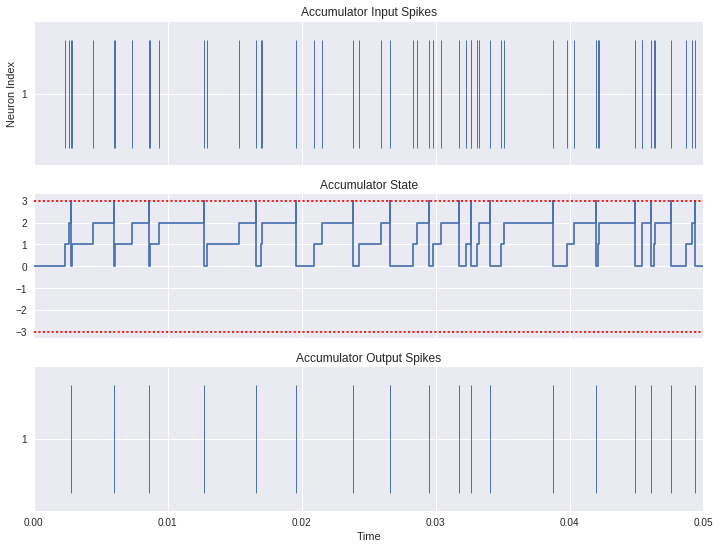

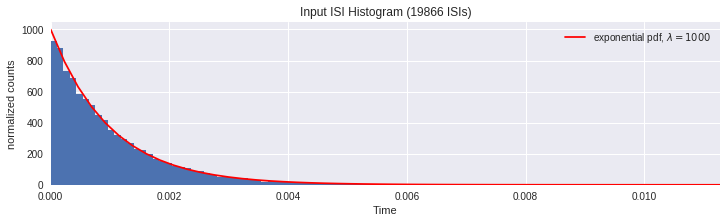

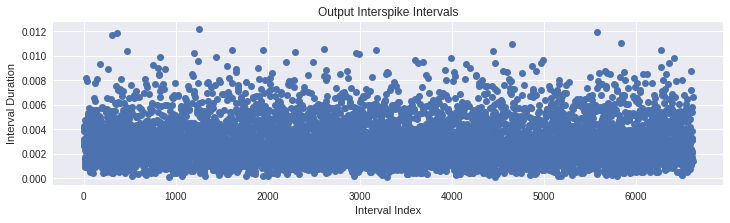

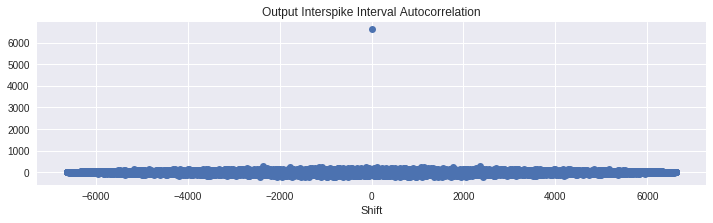

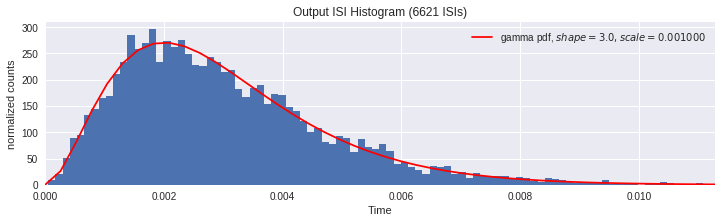

In [14]:
dat = run_poisson_neuron_experiment(weight=1, threshold=3)

As expected, the accumulator output ISIs are independent as checked by the autocorrelation and follow a gamma distribution.

### Threshold $\neq$ Multiple of Weight

When the threshold is not a multiple of the weight, we know that the output ISI will span different numbers of input spikes depending on the amount carried over from the previous ISI. In the following simulation, we set up the accumulator input spikes to have weight 2 while the accumulator has threshold 5 so that with each input spike, the accumulator state will progress as

0 -> 2 -> 4 -> 6 <br>
1 -> 3 -> 5 <br>
0 -> 2 -> 4 -> 6 <br>
...

The number of input spikes to trip the accumulator threshold alternates between 3 and 2; on average it takes 2.5 spikes to trip the accumulator threshold.

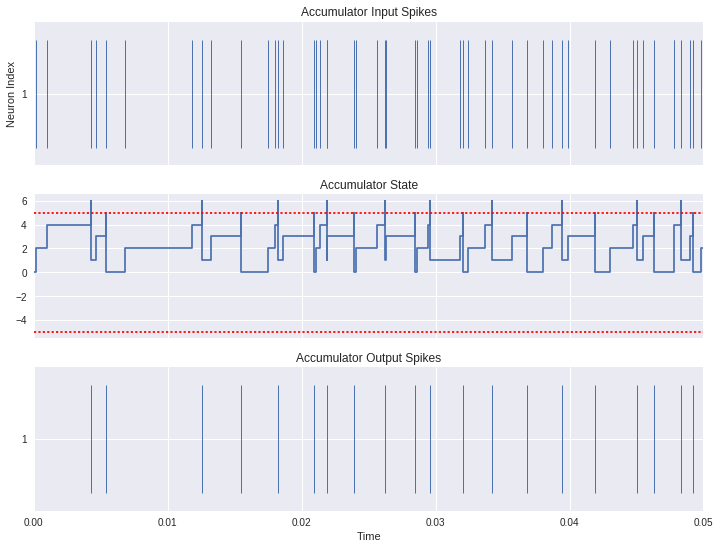

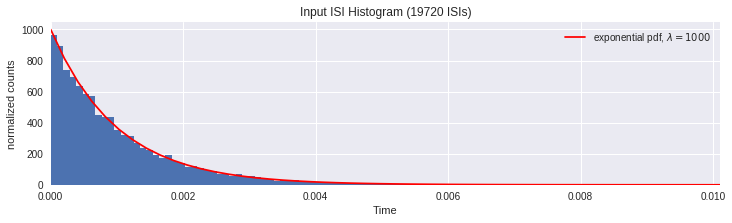

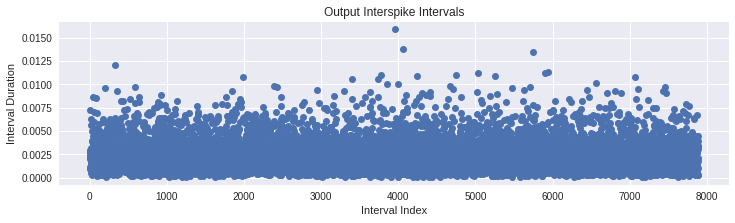

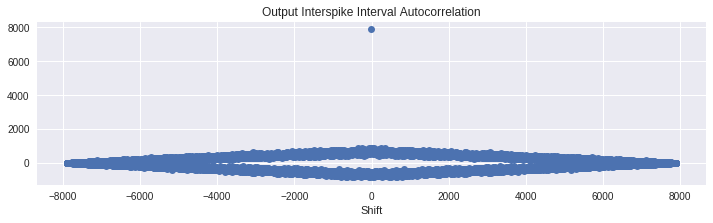

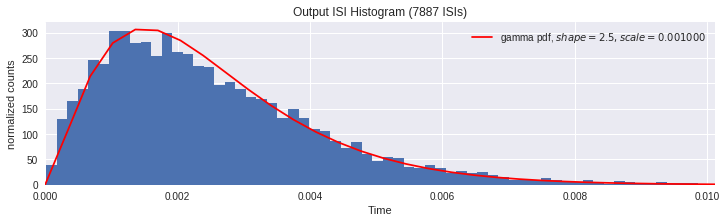

In [18]:
dat = run_poisson_neuron_experiment(weight=2, threshold=5)

As expected the output ISI are not indepdendent as reflected in the output ISI autocorrelation plot. If we split the even and odd ISIs and consider them separately, we see that indeed they follow gamma distributions with shape parameters of 2 and 3.

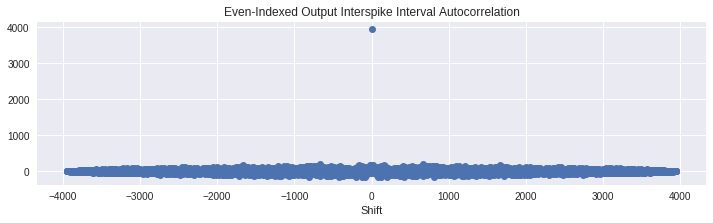

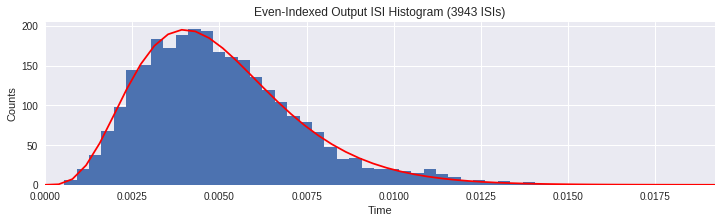

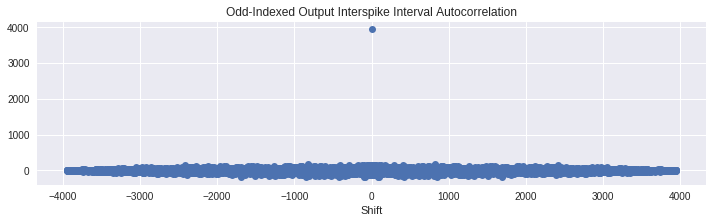

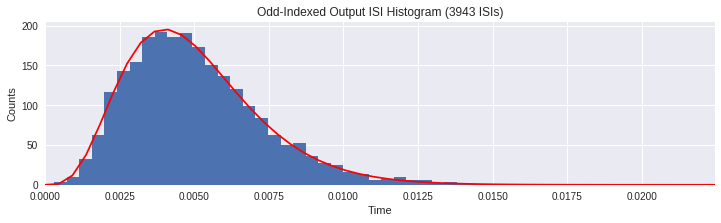

In [24]:
# TODO DEBUG indexing -> shape incorrect

ax = plot_isi(dat['spks_out'][::2], name="Even-Indexed Output ", plot_isi_bool=False, normed=True)['hist']
ax = plot_gamma(ax, shape=5, scale=1./1000)
ax = plot_isi(dat['spks_out'][1::2], name="Odd-Indexed Output ", plot_isi_bool=False, normed=True)['hist']
ax = plot_gamma(ax, shape=5, scale=1./1000)

As we increase the threshold relative to the weight though, each carry over has a smaller relative effect on the number of input spikes to produce an output spike. With a high threshold to weight ratio, we can approximate an IID gamma. [TODO expand]

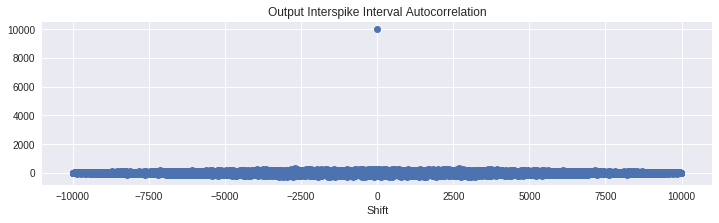

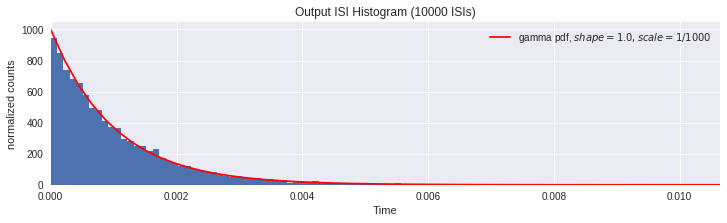

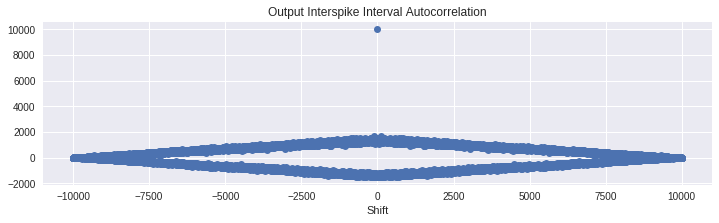

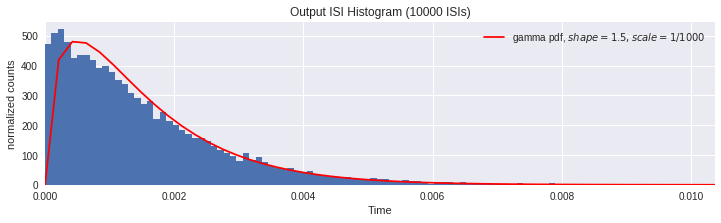

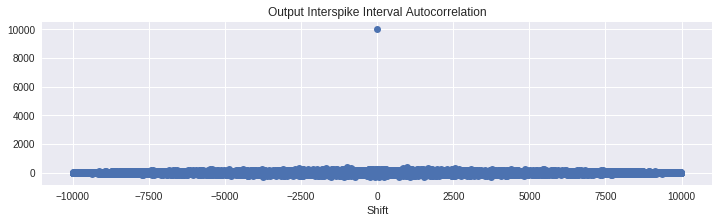

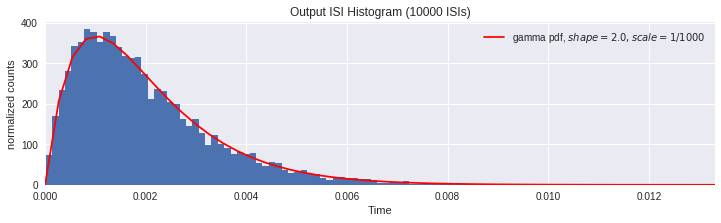

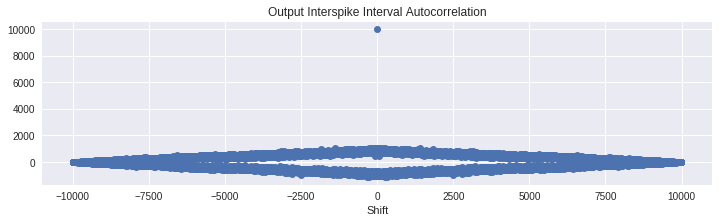

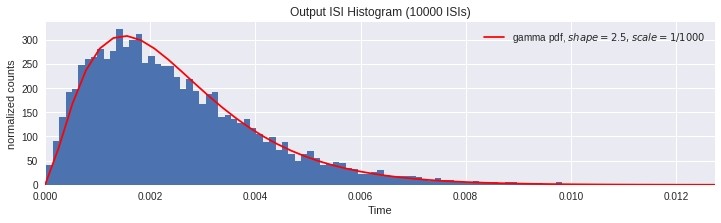

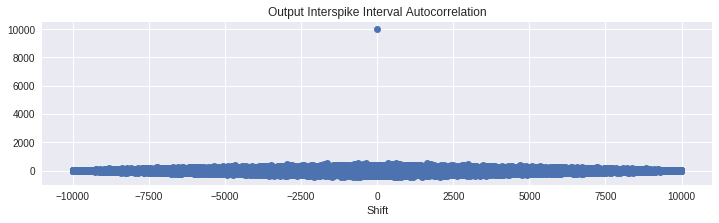

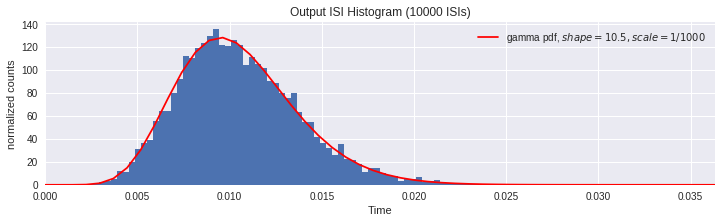

In [6]:
# vary thresholds
nspikes_out = 10000
weight = 2
for threshold in [2, 3, 4, 5, 21]:
    nspikes_in = int(np.ceil(float(threshold)/weight*nspikes_out)) + int(np.ceil(float(threshold/weight)))
    run_poisson_neuron_experiment(weight=weight, threshold=threshold, T=None,
        nspikes=nspikes_in, make_timeseries_plot=False, make_in_isi_plot=False,
        make_out_isi_plot=False)

However, we also notice that the output ISI autocorrelations for increasing non-weight-multiple thresholds seem to converge to the case where the threshold is a multiple of the weight.

[Could show integration of |autocorrelation| converges with threshold]

In operation, we expect many neurons with small weights to contribute to the accumulator state. 

## Many Neurons, Regular Spiking, Random Weights

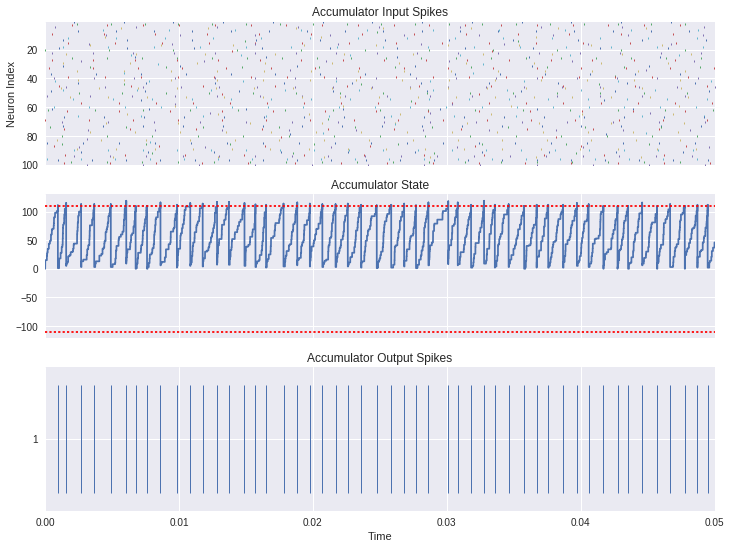

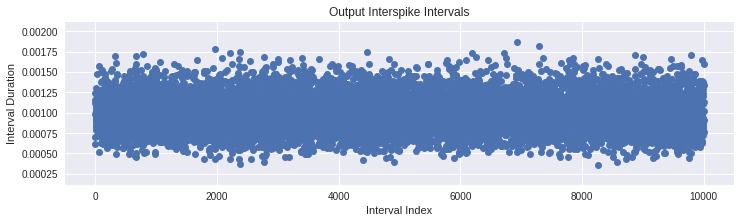

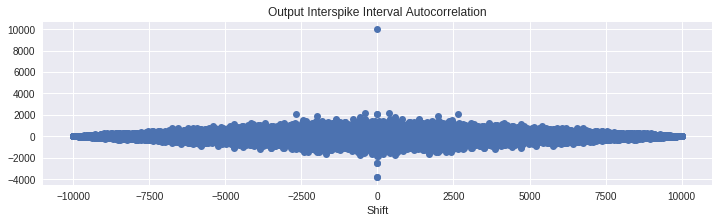

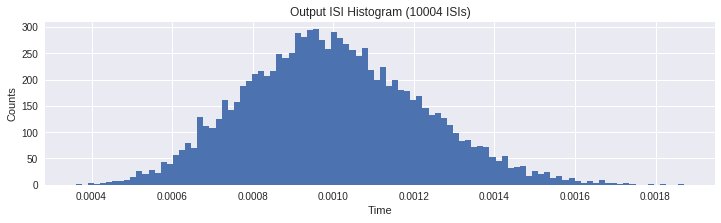

In [7]:
N = 100
input_rates = np.random.uniform(0, 400, size=N)
weights = np.random.randint(0, 11, size=N)
threshold = int(np.sum(input_rates*weights)/1000.)
T=10
pool = build_pool(N, input_rates=input_rates, weights=weights, threshold=threshold)
spks_in, acc_state, spks_out = run_experiment(pool, T=T)
plot_timeseries(spks_in, acc_state, spks_out, tmax=0.05, threshold=threshold)
axs = plot_isi(spks_out, bins=100)

-327.379720514


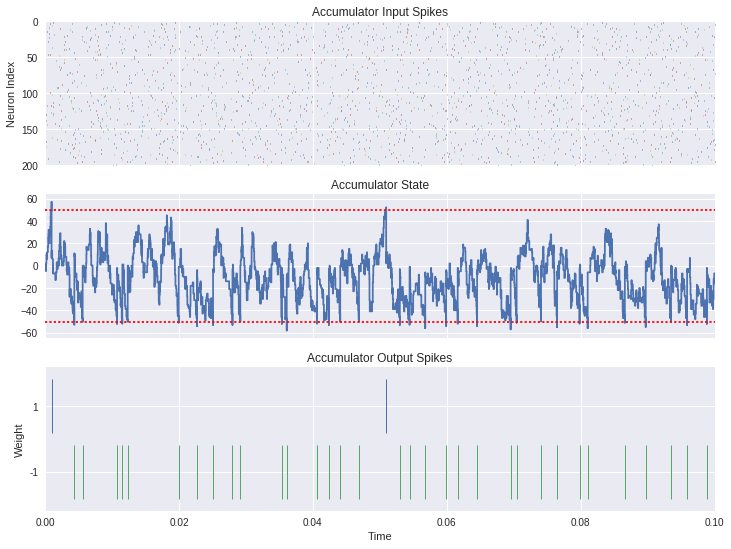

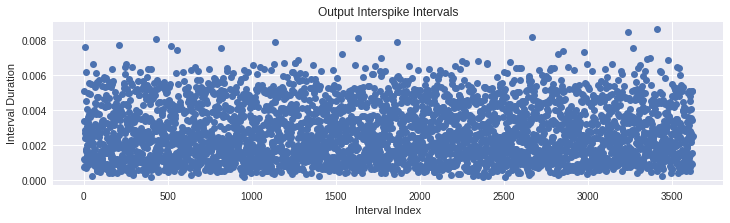

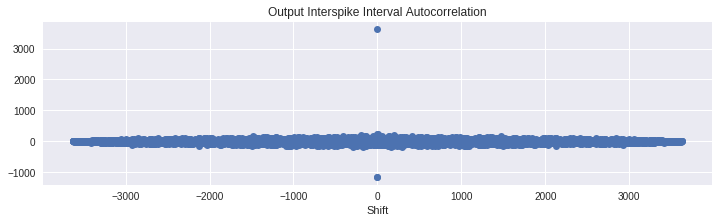

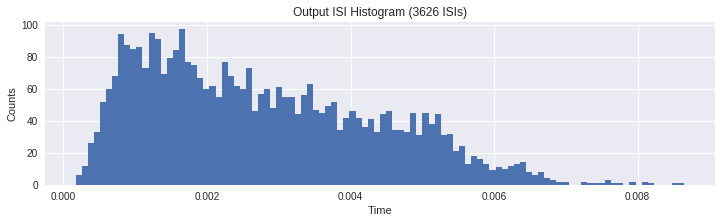

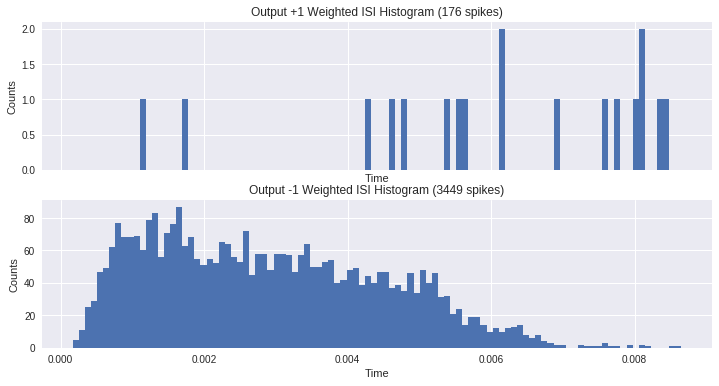

In [8]:
N = 200
np.random.seed(0)
input_rates = np.random.uniform(0, 200, size=N)
weights = np.random.randint(-10, 10, size=N)
threshold = 50
T=10.
pool = build_pool(N, input_rates=input_rates, weights=weights, threshold=threshold)
spks_in, acc_state, spks_out = run_experiment(pool, T=T)
plot_timeseries(spks_in, acc_state, spks_out, tmax=0.1, threshold=threshold)
axs = plot_isi(spks_out, bins=100)
print(compute_out_rate(pool, threshold))

# Nengo

In [9]:
def threshold_weights(weights):
    """compute the threshold and rounded weights from a given weight distribution
    """
    acc_wmax = np.array([1.] + [127./2**i for i in range(7, 14)])
    acc_unit = np.array([1./64] + [1./2**i for i in range(7, 14)])
    thresholds = np.array([2**i for i in range(6,14)])

    w_max = np.max(np.abs(weights))
    idx = np.argmax(w_max >= acc_wmax)-1
    w_rounded = np.rint(weights/acc_unit[idx]).astype(int)
    threshold = thresholds[idx]   
    return threshold, w_rounded


In [10]:
# build a network
N = 64
net = nengo.Network()
with net:
    stim = nengo.Node(lambda t: np.sin(2*np.pi*t), size_in=0, size_out=1)
    ens = nengo.Ensemble(N, 1)
    node = nengo.Node(lambda t, x: x, size_in=1, size_out=1)
    probe_in = nengo.Probe(stim)
    probe_out = nengo.Probe(node)
    nengo.Connection(stim, ens, synapse=0)
    conn = nengo.Connection(ens, node, function=lambda x: x, transform=1000)

sim = nengo.Simulator(net)

Building finished in 0:00:01.                                                                                                                                                                        


Simulating finished in 0:00:01.                                                                                                                                                                      


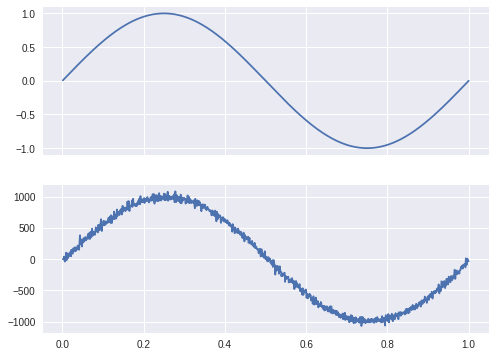

In [11]:
# check the network by running a simulation
sim.run(1)

fig, axs = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
# print(sim.data[probe])
# print(sim.trange())
axs[0].plot(sim.trange(), sim.data[probe_in])
axs[1].plot(sim.trange(), sim.data[probe_out])



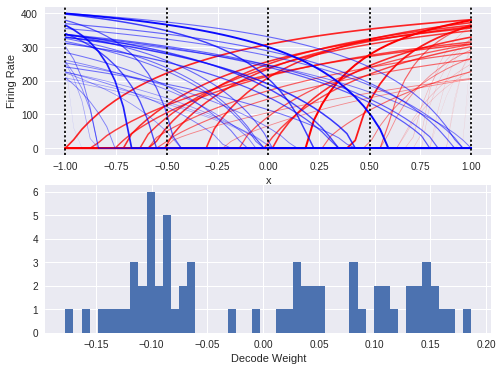

In [12]:
x_test = [-1, -0.5, 0, 0.5, 1]
fig, axs = plt.subplots(nrows=2, figsize=(8,6))
x, a = tuning_curves(ens, sim)

max_weight = np.max(np.abs(sim.data[conn].weights[0,:]))

for enc, color in zip([1, -1], ['r', 'b']):
    idx = (sim.data[ens].encoders == enc)[:,0]
    lines = axs[0].plot(x, a[:, idx], color)
    line_weights = np.abs(sim.data[conn].weights[0,idx])/max_weight
    for line, line_weight in zip(lines, line_weights):
        line.set_alpha(line_weight)
        line.set_linewidth(line_weight*2)
    
n, bins, patches = axs[1].hist(sim.data[conn].weights[0,:], bins=50)
axs[0].set_xlabel('x')
axs[0].set_ylabel('Firing Rate')
axs[1].set_xlabel('Decode Weight')

for xval in x_test:
    axs[0].axvline(xval, color='k', linestyle=':')

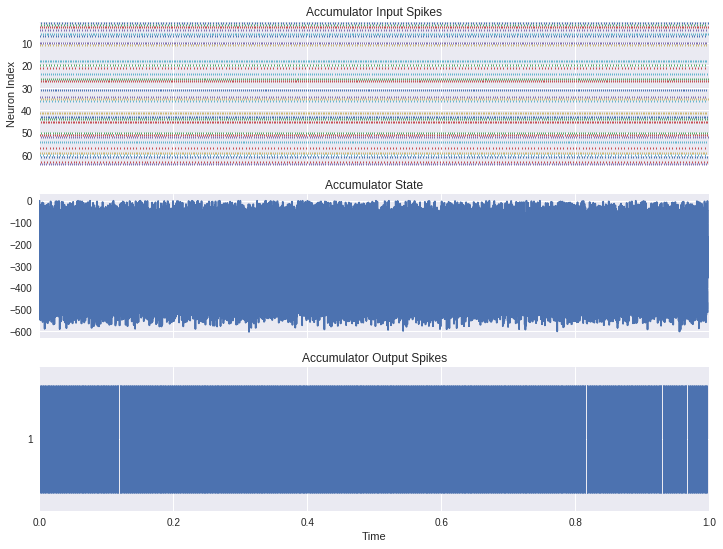

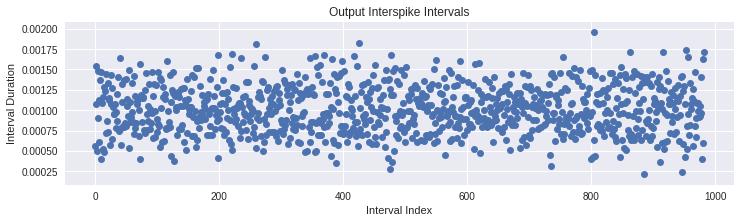

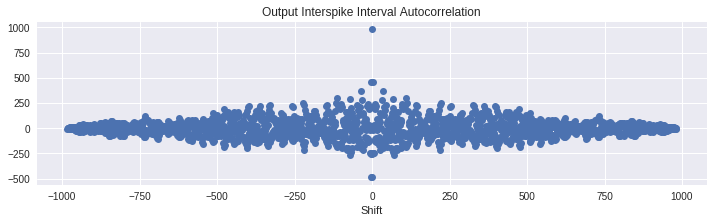

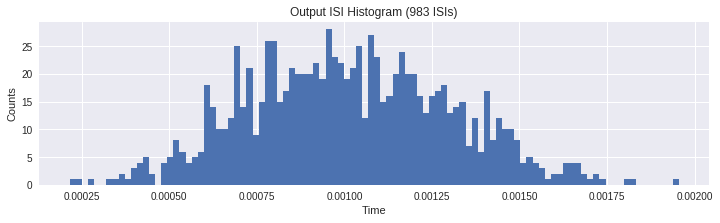

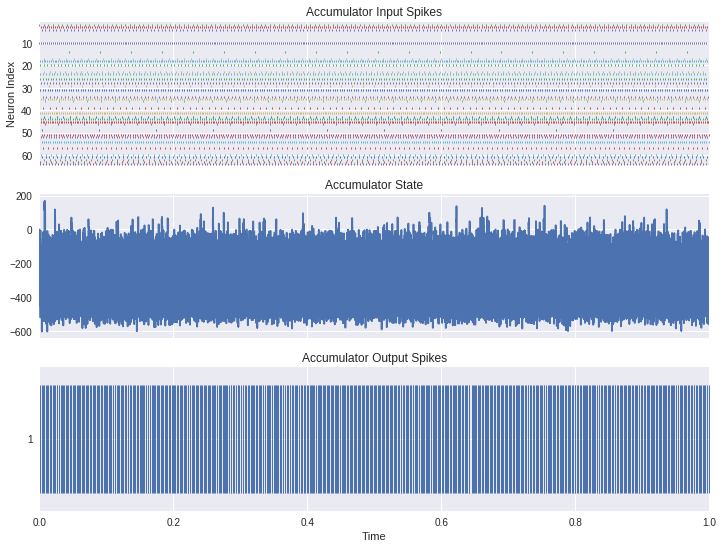

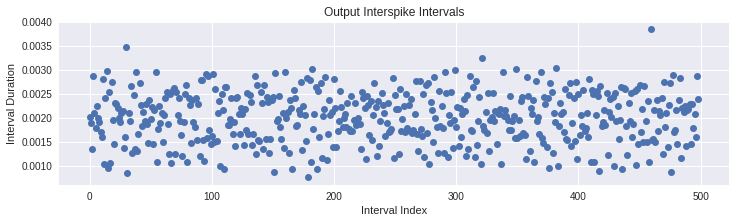

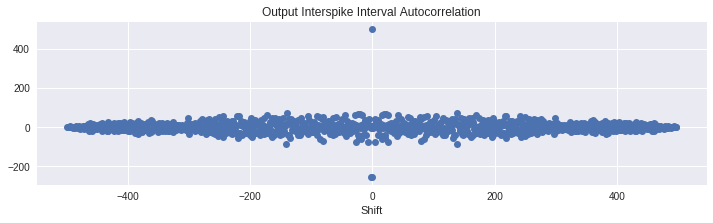

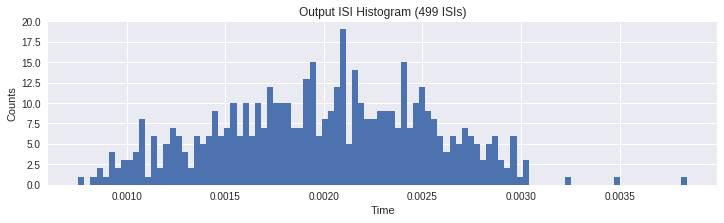

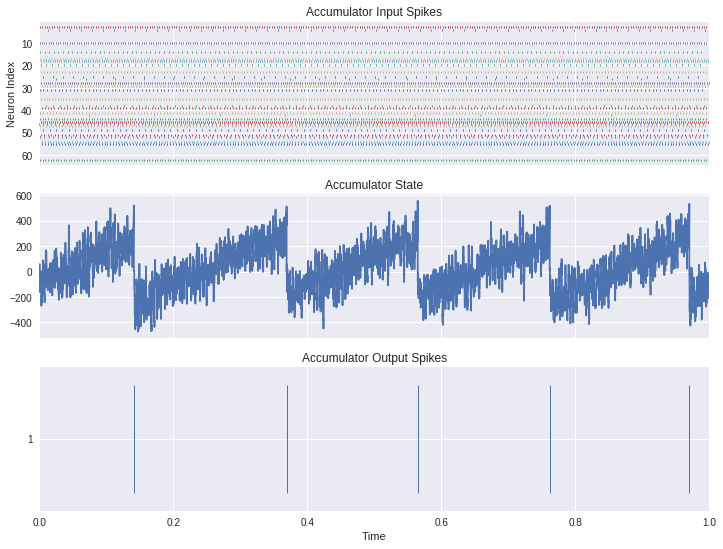

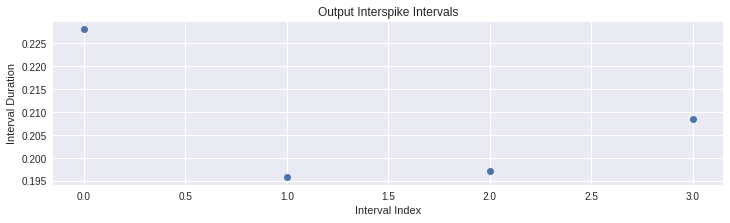

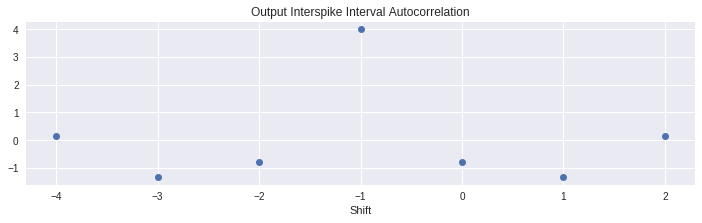

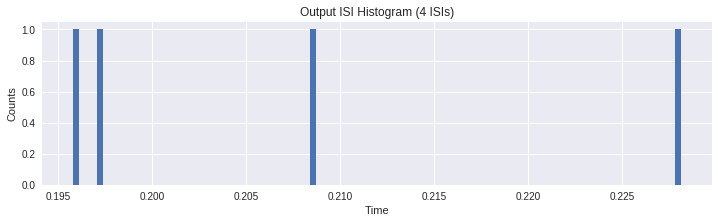

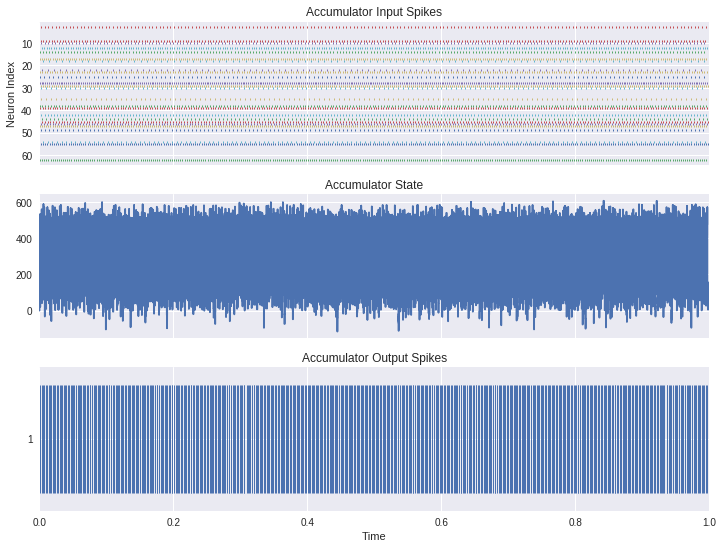

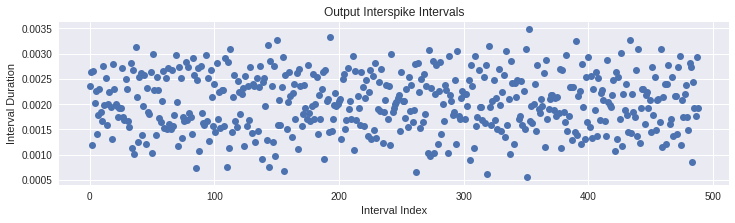

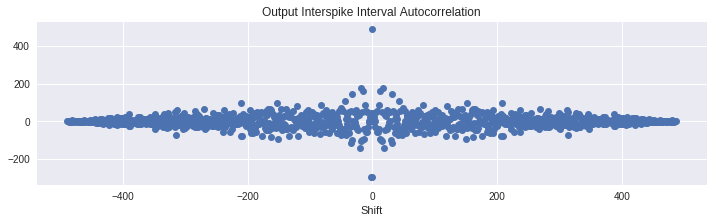

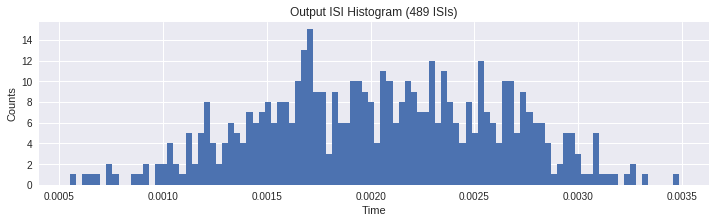

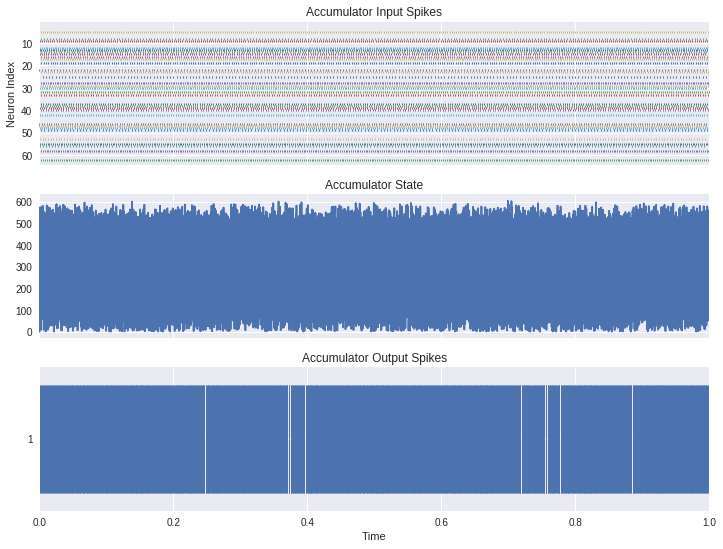

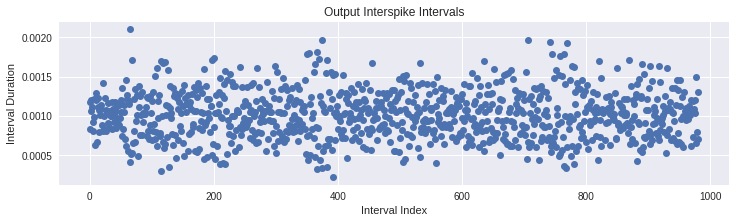

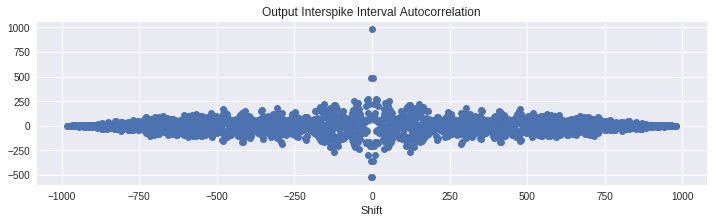

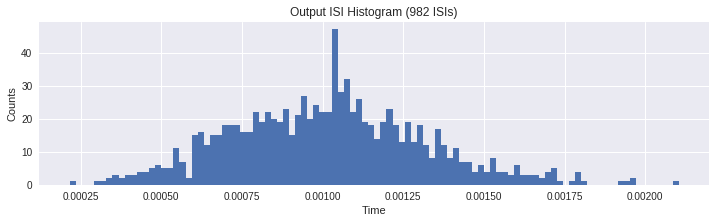

In [13]:
inputs = [-1, -0.5, 0, 0.5, 1]
# inputs = [-1]
for x_in in inputs:
    x, a = tuning_curves(ens, sim, inputs=np.array([x_in]))
    threshold, weights = threshold_weights(sim.data[conn].weights[0])
    pool = build_pool(N, input_rates=a, weights=weights, threshold=threshold)
    spks_in, acc_state, spks_out = run_experiment(pool, T=1.)
    plot_timeseries(spks_in, acc_state, spks_out, tmax=1.)
    plot_isi(spks_out, bins=100)

# Scratchpad

## Renewal Theory

The renewal process generalizes the Poisson process from having exponential inter-event intervals to any distribution inter-event intervals. The key property maintained is that the inter-event intervals are still IID.

Can the regular spiking neuron outputs be treated as a renewal process? Their interspike intervals are deterministic, so could they be cast as degenerate distributions which are independent and identical?

There are definite cases where the output spikes are not iid:
* The input spikes are not derived from a Poisson process
* The threshold is not a multiple of the all of the weights because of the accumulator state carry-over from one spike to the next.

## Palm-Khintchine Theorem

The Palm-Khintchine theorem states that the the super-position of a large number of renewal processes will have Poissonian properties. 
* How large is large?

If we can treat the input neuron spiking as a renewal process, then this theorem seems to apply.

It might be that we can just approximate the accumulator spike rate as a gamma. The threshold will surely not be a multiple of the weights when in a nengo network, but autocorrelation goes down as 